In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

## Solving the heat diffusion equation

We want to solve the [heat equation](https://en.wikipedia.org/wiki/Heat_equation)

$$
\frac{\partial u}{\partial t} = \dot{u} = u_{t} = a^2 u_{xx} = a^2 \frac{\partial^2 u}{\partial x^2} = a^2 \triangle u = a^2 \nabla^2 u
$$

So we think of having a 1-dimensional function $u(x)$.
Its Fourier transform we denote as $\hat{u}(\kappa)$. 

To remind myself what happens at integration or differentiation I think of terms proportional to 
$$
e^{i\kappa x}
$$

So, the second derivative with respect to position, $x$, brings down two times the factor $i\kappa$, so $(i\kappa)^2=-\kappa^2$. 
Consequently if we apply the Fourier transform to both sides of our equation we arrive at

$$
{d\hat{u}(\kappa) \over dt} =  - a^2 \kappa^2 \hat{u}(\kappa).
$$

Wow. This says that the Fourier coefficients all just decay with $a^2\kappa^2$ exponentially. 
This is exactly why Fourier worked on this and how he managed to solve this equation. 
So in principle we would not have to do this numerically but we use this as our first example to demonstrate how this solution strategy is implemented in code. 
Once we know this we can "graduate" to use a similar strategy for more complex equations. 

In [2]:
a = 0.02    # Thermal diffusivity constant
L = 2  # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = .1
t = np.arange(0,100,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * kappa**2 * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args=(kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

u = np.zeros_like(uhat)

for ct in range(len(t)):
    u[ct,:] = np.fft.ifft(uhat[ct,:])

u = u.real    

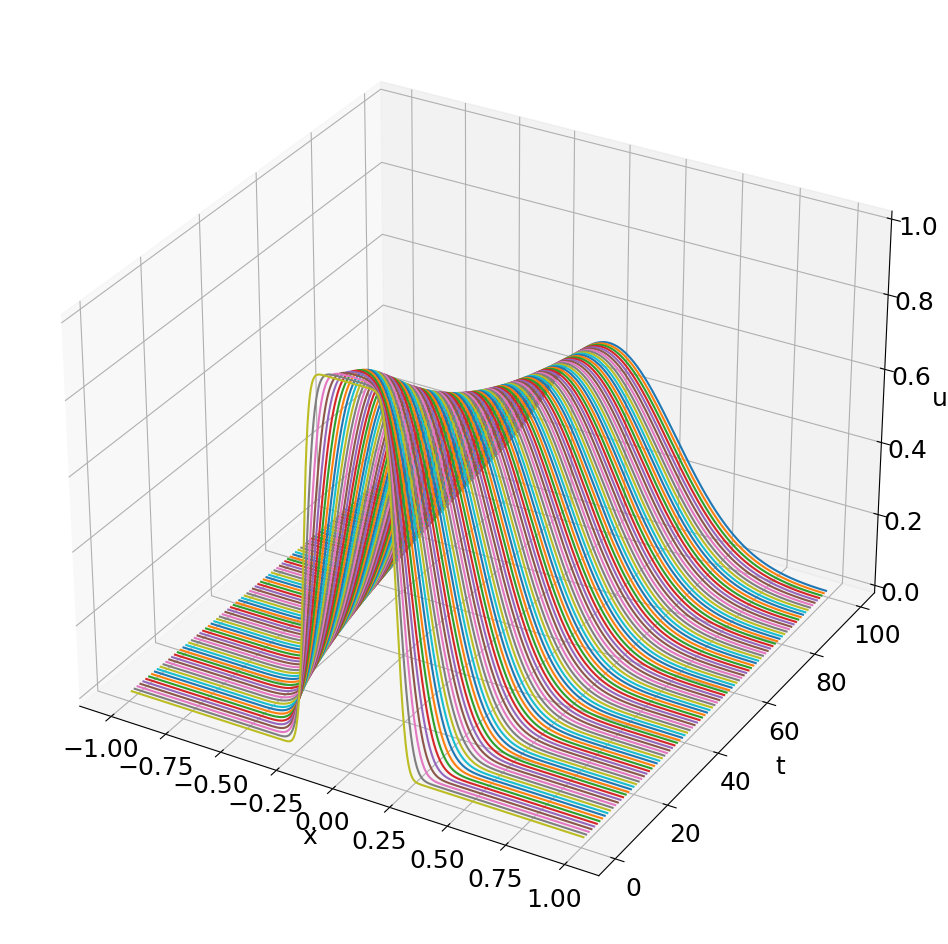

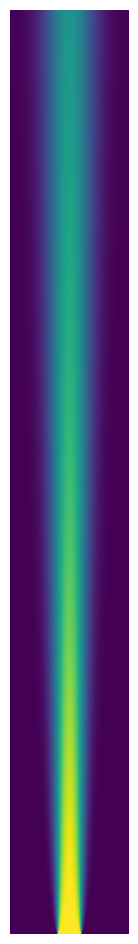

In [3]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]-1,0,-1):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("u")
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8)
plt.axis('off')

plt.show()

Now let's try a propagating wave equation:

$$
u_t - c u_x = 0
$$

which looks like

$$
{d \hat{u}(\kappa) \over dt} = c {du(x) \over dx} = - i\kappa\, c\, \hat{u}(\kappa)
$$

after Fourier transform.

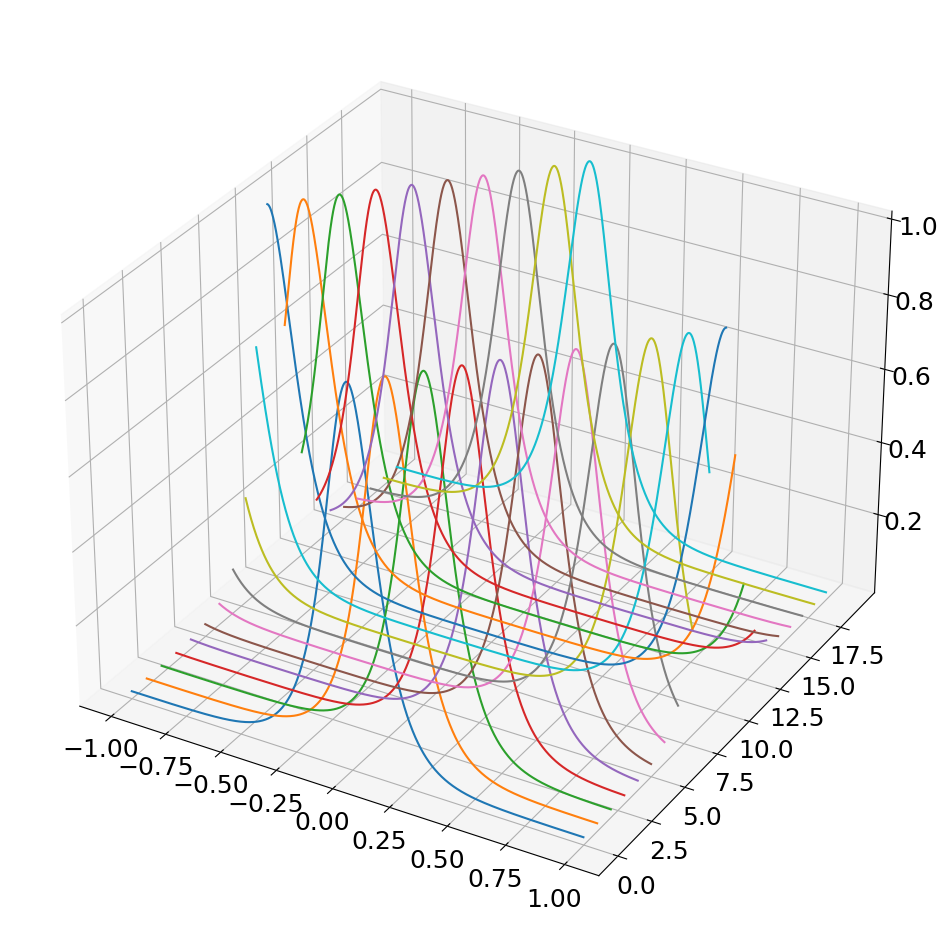

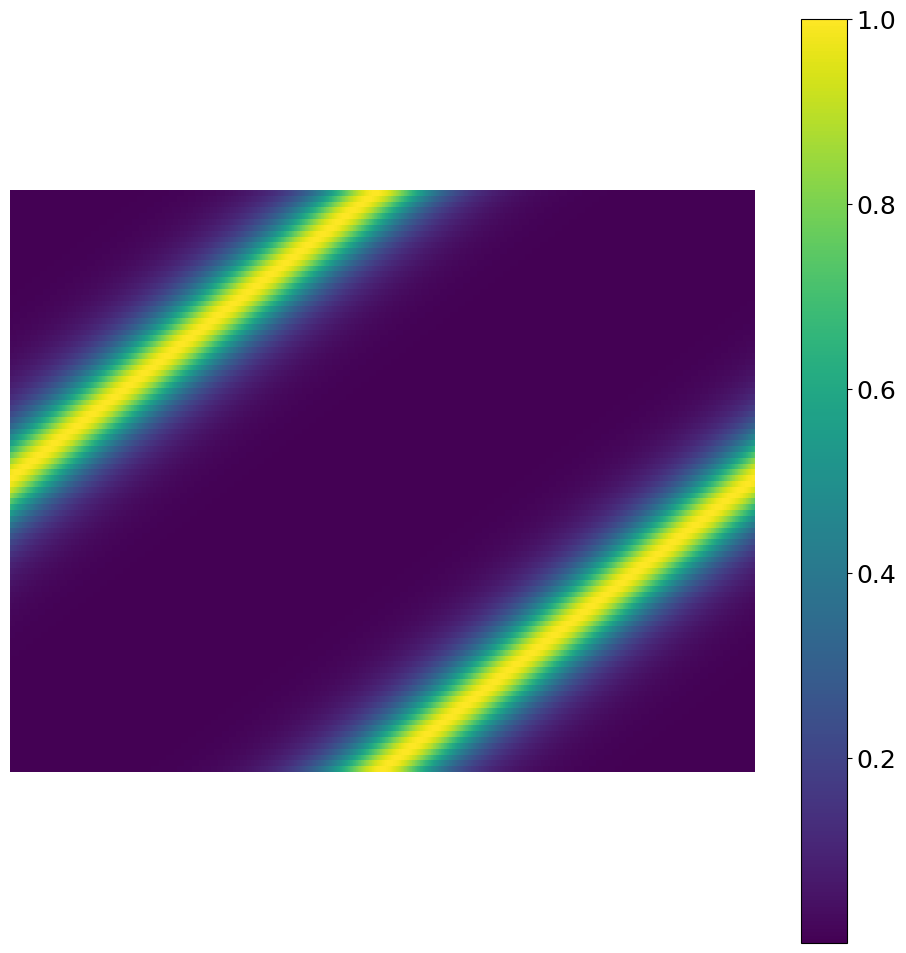

In [4]:

c = 2    # Wave speed
L = 2   # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.01
t = np.arange(0,100*dt,dt)

def rhsWave(uhat_ri,t,kappa,c):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -c*(1j)*kappa*uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsWave, u0hat_ri, t, args=(kappa,c))
uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

# Alternatively, simulate in spatial domain
def rhsWaveSpatial(u,t,kappa,c):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real
    du_dt = -c*d_u
    return du_dt

u = odeint(rhsWaveSpatial,u0,t,args=(kappa,c))

# Inverse FFT to bring back to spatial domain
#u = np.zeros_like(uhat)

#for k in range(len(t)):
#    u[k,:] = np.fft.ifft(uhat[k,:])

#u = u.real   

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:5,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8, interpolation="none")
plt.colorbar()
plt.axis('off')
plt.show()

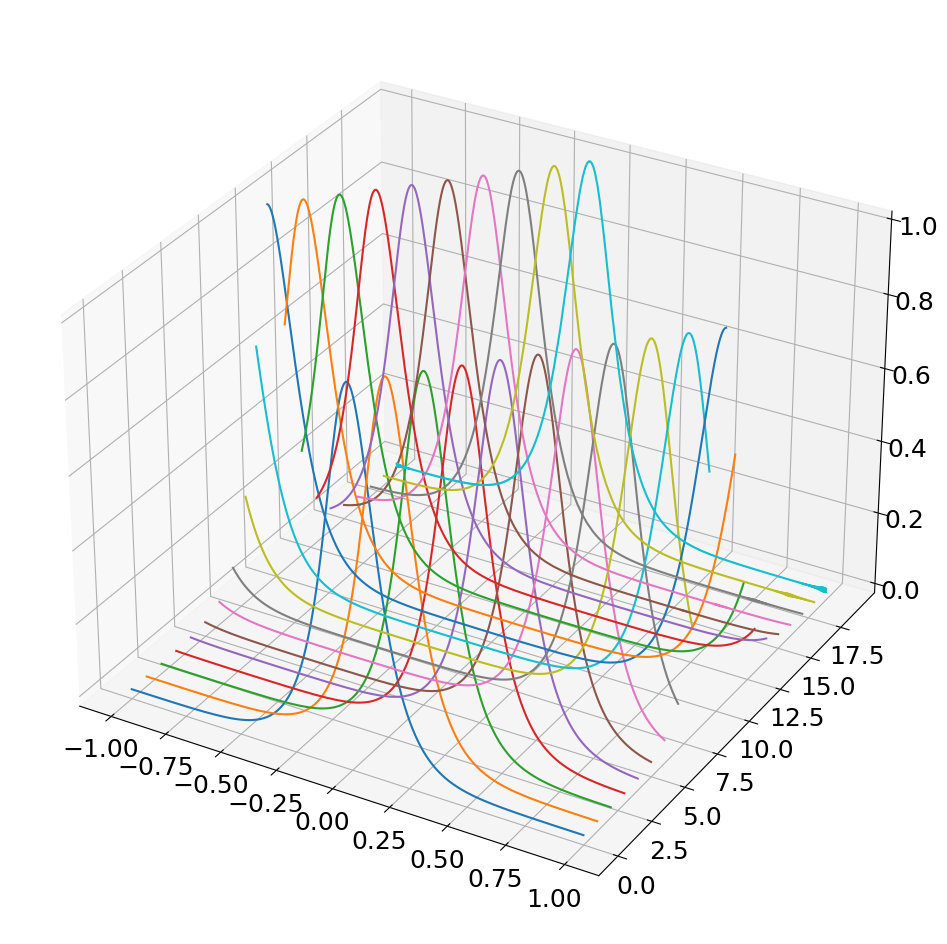

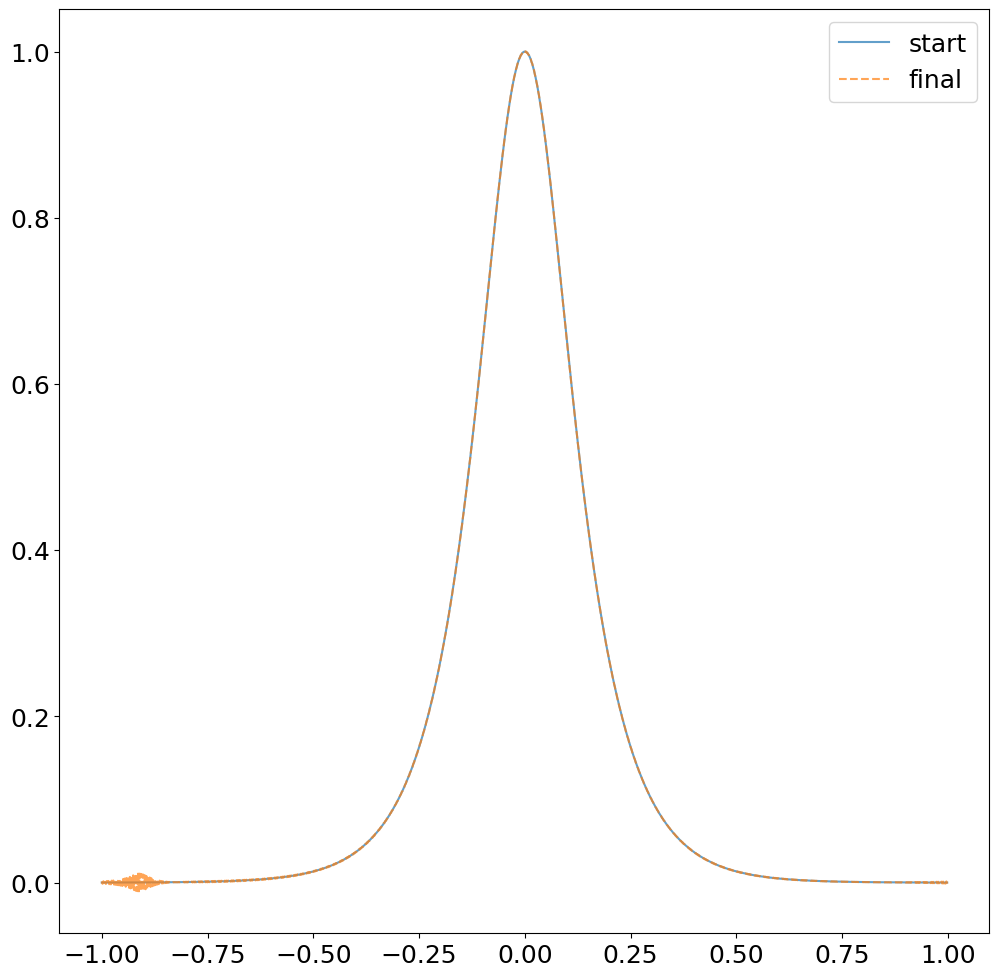

In [5]:
c = 2    # Wave speed
L = 2   # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.01
t = np.arange(0,101*dt,dt)

# Alternatively, simulate in spatial domain
def rhsWaveSpatial(u,t,kappa,c):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real
    du_dt = -c*d_u
    return du_dt

u = np.zeros((len(t),N))
u[0,:] = u0
for i in range(1,len(t)):
#u = odeint(rhsWaveSpatial,u0,t,args=(kappa,c)) 
    u_old = u [i-1,:] 
    u_new = u_old.copy()
    Ns = 100
    for j in range(Ns): # substepping
        uint = u_old + dt/2/Ns*rhsWaveSpatial(u_old,t, kappa,c)
        u_new = u_old + dt/Ns*rhsWaveSpatial(uint,t, kappa,c)
        u_old = u_new
    u[i,:] = u_new
# Inverse FFT to bring back to spatial domain
#u = np.zeros_like(uhat)

#for k in range(len(t)):
#    u[k,:] = np.fft.ifft(uhat[k,:])

u = u.real   

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:5,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])

fig2 = plt.figure()
plt.plot(x, u[0,:],alpha=0.7,label="start")
plt.plot(x, u[-1,:],"--",alpha=0.7,label="final")
plt.legend();


### In class exercise

Let's replace the scipy odeint with the newer [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) integrator. 
It supports complex variable integration and hence we should be able to simplify the the calls in our examples above and feed in directly the complex values. 

Redo the solution of the heat equation above. 

In [45]:
from scipy.integrate import solve_ivp

a = 0.02    # Thermal diffusivity constant
L = 2  # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# Simulate in Fourier frequency domain
dt = 1
t = np.arange(0,100,dt)

def rhsHeat(t, uhat, kappa,a):
    d_uhat = -a**2 * kappa**2 * uhat
    return d_uhat

sol = solve_ivp(rhsHeat, (t[0],t[-1]), u0hat, args=(kappa,a), t_eval=t, )

u = np.zeros_like(sol.y)

for ct in range(len(t)):
    u[:,ct] = np.fft.ifft(sol.y[:,ct])

u = u.real    


In [46]:
u_plot = (u[:,0:-1:1]).T
u_plot.shape

(99, 1024)

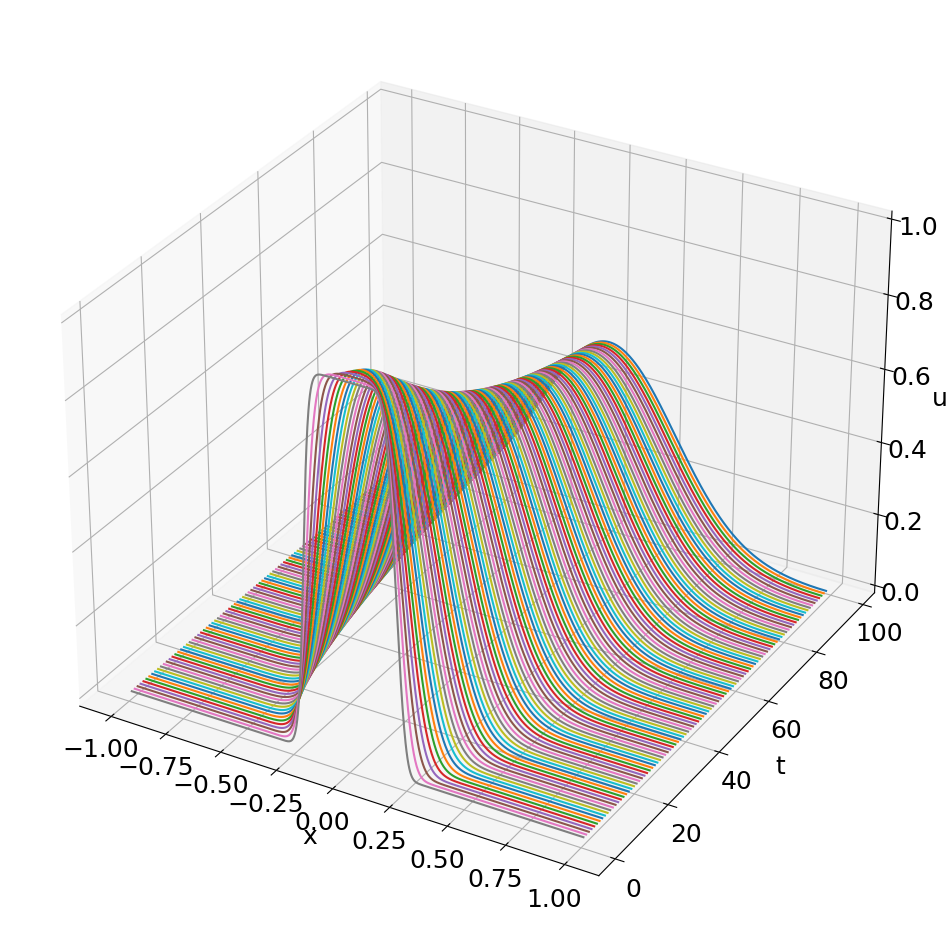

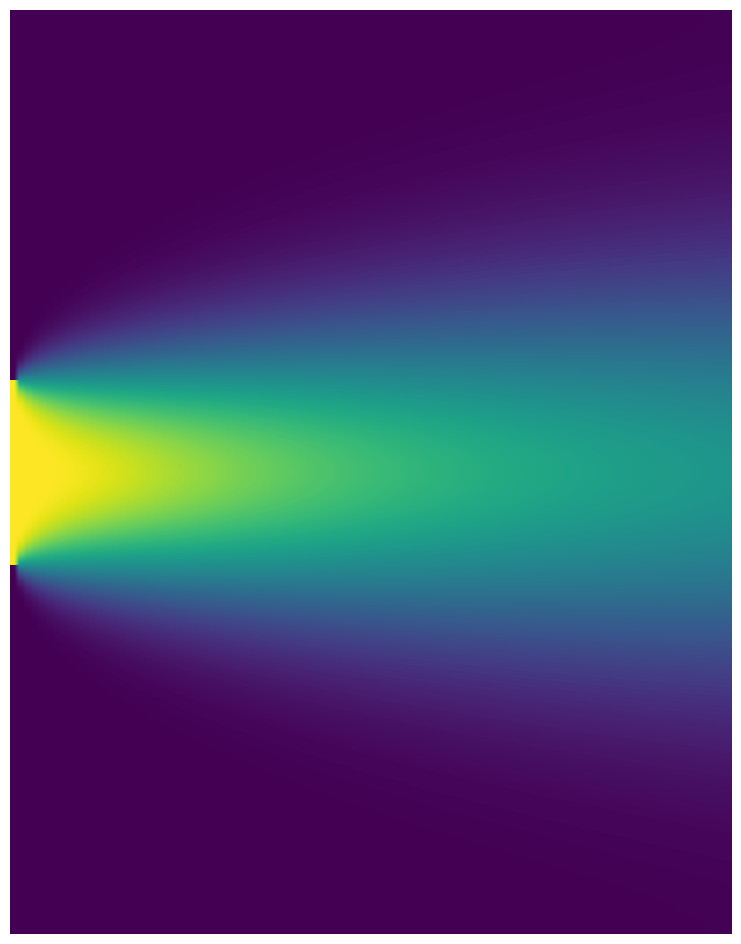

In [49]:

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]-1,0,-1):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("u")
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u),aspect=1/8)
plt.axis('off')

plt.show()

In [39]:
x.shape,ys.shape,u_plot[10,:].shape

((1024,), (100,), (100,))

In [22]:
ys.shape

(100,)

In [42]:
u_plot.shape[0]

99